# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# lets see quick information about the dataset
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

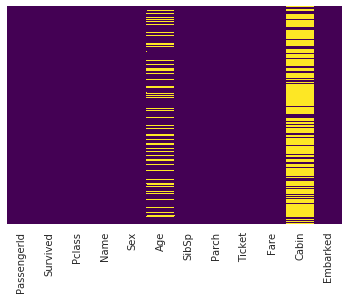

In [4]:
# creating the heatmap to find the columns with the most missing data
# here we dont want a ticklabels on the y axis, also we don't want color bar as well 
sns.heatmap(data=train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [5]:
# and we can get the exact number of the null values using isnull().sum() in each columns
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"**

### Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.


In [6]:
# lets get a count of who survived and who did not survive
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

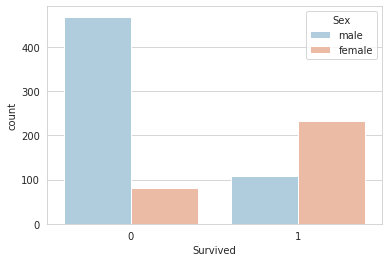

In [7]:
# lets create a count plot to visualize the ratio of people died to people lived
sns.countplot(x='Survived', data=train, hue='Sex', palette='RdBu_r') 

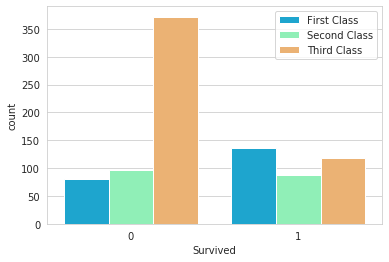

In [8]:
# lets see how many people survived or died from each passenger class
sns.countplot(x='Survived', data=train, hue='Pclass', palette='rainbow')
plt.legend(labels=['First Class', 'Second Class', 'Third Class'])

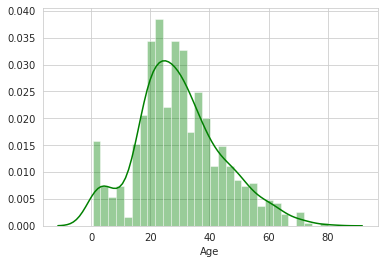

In [9]:
# Lets see the age of people on the titanic
sns.distplot(a=train['Age'].dropna(), kde=True, bins=30, color='green')

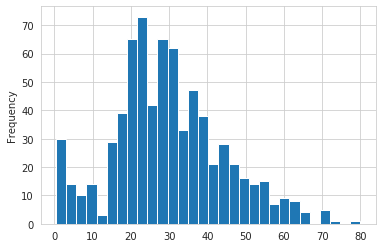

In [10]:
# You can do the above plot directly from pandas visualizatoins
train.Age.plot.hist(bins=30)
# you can also use train['Age']

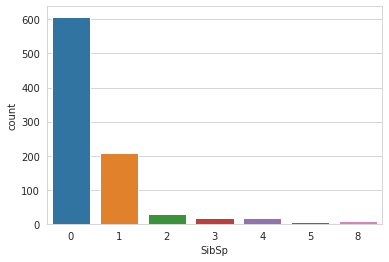

In [11]:
# lets explore the number of sibling or spouses on the titanic
sns.countplot(x='SibSp', data=train)
# this tells us that most number on board have no Children or Spouse, the second most is 1 which usually indicates
# a Spouse

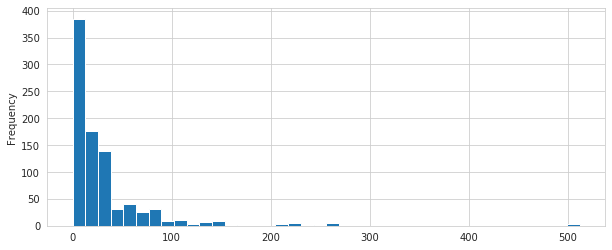

In [12]:
train['Fare'].plot.hist(bins=40, figsize=(10,4))
# Notice that most of the people paied between 0 and 50 USD for tickets
# reflecting the number of people in each class

### Cufflinks for plots
___
 Let's take a quick moment to show an example of cufflinks!

In [13]:
# Doing the above plot with cufflinks
# importing cufflinks and setting offline mode
import cufflinks as cf
cf.go_offline()

In [14]:
# Now let plot the histogram again and see the change (it will come to live 'becomes interactive')
train['Fare'].iplot(kind='hist', bins=30)

 ___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

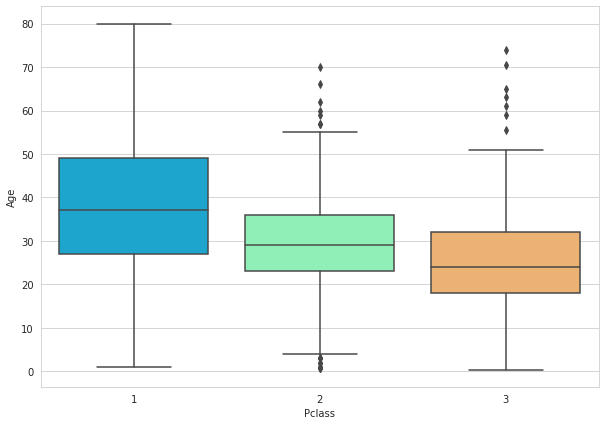

In [15]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=train, palette='rainbow')
# We notice that most of the people in the third class are younger and people in the first class
# are older meaning that their wealth took a lot of time to accumulate
# we can build a simple Linear Regression Model to predict the null values in the Age column based on the
# other Features in the dataset but we are gonna use the average Age of each Passenger class
# to impute the null values of the Age column

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [16]:
def impute_age(cols):
    """Imputing the missing values of the Age column according to the Passenger class column"""
    Age=cols[0]
    Pclass=cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            # if they are on the first class
            return int(train[train['Pclass'] == 1]['Age'].mean())
        elif Pclass ==2:
            # if they are on the second class
            return int(train[train['Pclass'] == 2]['Age'].mean())
        else:
            # if they are on the third class
            return int(train[train['Pclass'] == 3]['Age'].mean())
    else:
        # if age is not null
        return Age

Now lets apply the impute_age function 

In [17]:
# lets apply the impute age function on the train['Age'] column (axis=1) as i want to run this function
# across the columns
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1) # we are calling apply on the two columns #Age, #Pclass

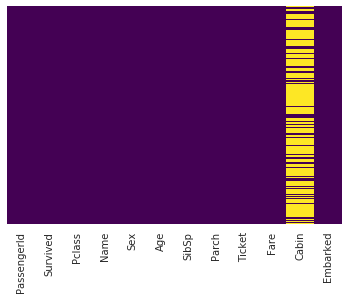

In [18]:
# lets go a head and check the heatmap again
sns.heatmap(data=train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.**

In [19]:
train.drop(labels='Cabin', axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


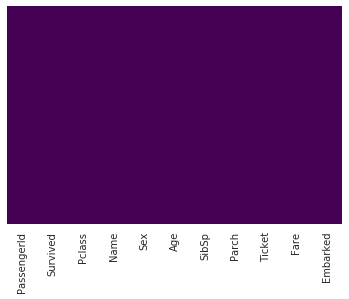

In [20]:
# Lets check the heatmap again
sns.heatmap(data=train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [21]:
# see the number of null values still exist
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [22]:
# Dropping the NaN values in the Embarked column as they are too small so we can ignore them
train.dropna(inplace=True, axis=0, how='any')

In [23]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [24]:
sex = pd.get_dummies(data=train['Sex'], drop_first=True)
# one column is a perfect predictors for the second column which may mess our model
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [25]:
embark = pd.get_dummies(data=train['Embarked'], drop_first=True)
embark # dropped the c column as the other two are perfect predictors of it

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [26]:
# lets concatenate the new columns created to the original dataframe
train = pd.concat([train, sex, embark], axis=1)

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [28]:
# Now we can drop the encoded columns like (SEX, EMBARKED)
# in addtion to other columns that we are not gonna use like (NAME, TICKET)
train.drop(labels = ['Sex', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)
train.head() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [29]:
train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
886,887,0,2,27.0,0,0,13.00,1,0,1
887,888,1,1,19.0,0,0,30.00,0,0,1
888,889,0,3,25.0,1,2,23.45,0,0,1
889,890,1,1,26.0,0,0,30.00,1,0,0
890,891,0,3,32.0,0,0,7.75,1,1,0


In [30]:
# Also the passenger id is not important or not related to the survival of the Passenger so we
# Can drop it as well
train.drop(labels=['PassengerId'], axis=1, inplace=True)
train.head() # Now our dataframe is perfect for our machine learning model

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Try again training the model with this cell after already training it with the Pclass as a normal column

```python
# NOTE: the Pclass column can be considered a categorical column that takes values(1 or 2 or 3) 
# so we can call get dummies on it
p_class = pd.get_dummies(data=train['Pclass'], drop_first=True)
# lets drop and add this new columns 'p_class' to the 'train' dataframe
train = pd.concat([train, p_class], axis=1)
train.drop(labels='Pclass', axis=1, inplace=True)
train.head()
```

In [31]:
p_class = pd.get_dummies(data=train['Pclass'], drop_first=True)
# lets drop and add this new columns 'p_class' to the 'train' dataframe
train = pd.concat([train, p_class], axis=1)
train.drop(labels='Pclass', axis=1, inplace=True)
train.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
x = train.drop(labels='Survived', axis=1)
y = train['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [33]:
x_train.head()

,Age,SibSp,Parch,Fare,male,Q,S,2,3
807,18.0,0,0,7.775,0,0,1,0,1
651,18.0,0,1,23.000,0,0,1,1,0
2,26.0,0,0,7.925,0,0,1,0,1
690,31.0,1,0,57.000,1,0,1,0,0
196,25.0,0,0,7.750,1,1,0,0,1


In [34]:
y_train.head()

807    0
651    1
2      1
690    1
196    0
Name: Survived, dtype: int64

## Training and Predicting

In [35]:
# importing the Logistic Regression
from sklearn.linear_model import LogisticRegression
# initializing our Estimator
log_model = LogisticRegression(max_iter=10000) # you need to increase the maximum iterators to not get warning
# fitting the model on our data
log_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
predictions = log_model.predict(x_test)

In [37]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

___
### Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



In [39]:
# We can also get the confusion metrics by the following
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true=y_test, y_pred=predictions))

[[149  14]
 [ 33  71]]


In [40]:
# lets check the score or accuracy of our prediction
log_model.score(x_test, y_test)

0.8239700374531835

## Good, Now lets try different feature engineering to get better results